In [48]:
import time

# work with directories
import os 
from pathlib import Path 

# datetime
import datetime as dt

# work with data
import numpy as np
import pandas as pd
# import pandas_datareader.data as web # not needed for this code

# visualize data
import matplotlib.pyplot as plt
import seaborn as sns

# create bag of word vector
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# gensim
import pyLDAvis.gensim_models
from gensim.models import LdaMulticore, TfidfModel
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
import gensim._matutils
import multiprocessing
import IPython

import warnings
warnings.filterwarnings("ignore")


### 1. Load data

Here we load the data for each company from the 'Consumer Staples' sector. The files were generated in `1_Data_Preprocessing.ipynb`

In [3]:
chd_df = pd.read_csv("../data/CHD.csv")
print(chd_df.shape)
chd_df.head(5)

(70, 7)


,text,patent_id,ticker,numpat_total,issue_date,sector,clean_corpus
0,FIELD OF THE INVENTION\n\nThe present inventio...,7665418,CHD,395,2/23/2010,Consumer Staples,field invent present invent relat absorb compo...
1,FIELD OF THE INVENTION\n\nThe present inventio...,7723629,CHD,395,5/25/2010,Consumer Staples,field invent present invent relat field toothb...
2,RELATED APPLICATIONS AND PATENTS\n\nThe presen...,7763454,CHD,395,7/27/2010,Consumer Staples,relat applic patent present invent relat u.s. ...
3,FIELD OF THE INVENTION\n\nThe present inventio...,7772578,CHD,395,8/10/2010,Consumer Staples,field invent present invent relat diagnost tes...
4,FIELD OF THE INVENTION\n\nThe invention relate...,7776618,CHD,395,8/17/2010,Consumer Staples,field invent invent relat diagnost assay analy...


In [4]:
cl_df = pd.read_csv("../data/CL.csv")
print(cl_df.shape)
cl_df.head(5)

(335, 7)


,text,patent_id,ticker,numpat_total,issue_date,sector,clean_corpus
0,This invention is directed to a dispensing con...,7690531,CL,3401,4/6/2010,Consumer Staples,invent direct dispens contain enhanc appear pa...
1,BACKGROUND OF THE INVENTION\n\nHard surface cl...,7700536,CL,3401,4/20/2010,Consumer Staples,background invent hard surfac cleaner usual wa...
2,FIELD OF THE INVENTION\n\nThe present inventio...,7703163,CL,3401,4/27/2010,Consumer Staples,field invent present invent relat toothbrush m...
3,BACKGROUND OF THE INVENTION\n\nThe efficacy of...,7704531,CL,3401,4/27/2010,Consumer Staples,background invent efficaci antiperspir salt in...
4,BACKGROUND OF THE INVENTION\n\nThe present inv...,7707677,CL,3401,5/4/2010,Consumer Staples,background invent present invent direct manual...


In [5]:
cpb_df = pd.read_csv("../data/CPB.csv")
print(cpb_df.shape)
cpb_df.head(5)

(4, 7)


,text,patent_id,ticker,numpat_total,issue_date,sector,clean_corpus
0,FIELD OF THE INVENTION\n\nThe present inventio...,8463423,CPB,137,6/11/2013,Consumer Staples,field invent present invent relat general syst...
1,FIELD OF THE INVENTION\n\nThe present inventio...,9066627,CPB,137,6/30/2015,Consumer Staples,field invent present invent relat instant food...
2,BACKGROUND OF THE INVENTION\n\n1. Field of Inv...,9193510,CPB,137,11/24/2015,Consumer Staples,background invent 1. field invent invent relat...
3,FIELD OF THE INVENTION\n\nThe present inventio...,9873603,CPB,137,1/23/2018,Consumer Staples,field invent present invent relat apparatus fi...


In [6]:
hsy_df = pd.read_csv("../data/HSY.csv")
print(hsy_df.shape)
hsy_df.head(5)

(18, 7)


,text,patent_id,ticker,numpat_total,issue_date,sector,clean_corpus
0,FIELD OF THE INVENTION AND INTRODUCTION\n\nThe...,7641930,HSY,27,1/5/2010,Consumer Staples,field invent introduct invent relat novel meth...
1,FIELD OF THE INVENTION\n\nThis invention gener...,7721908,HSY,27,5/25/2010,Consumer Staples,field invent invent general relat hand-held co...
2,FIELD OF THE INVENTION\n\nThis invention relat...,7829127,HSY,27,11/9/2010,Consumer Staples,field invent invent relat general calcium fort...
3,FIELD OF THE INVENTION AND INTRODUCTION\n\nThe...,7919135,HSY,27,4/5/2011,Consumer Staples,field invent introduct invent relat new bevera...
4,FIELD OF THE INVENTION\n\nThe invention relate...,8088431,HSY,27,1/3/2012,Consumer Staples,field invent invent relat food product ingredi...


In [7]:
sector_df = pd.concat([chd_df, cl_df], axis=0)
sector_df = pd.concat([sector_df, cpb_df], axis=0)
sector_df = pd.concat([sector_df, hsy_df], axis=0)
sector_df.shape

(427, 7)

### 2. Corpus data

Here we create the dataframes including only the patent_id and clean_corpus for each company.

In [8]:
# Helper functions

def sort_by_date(df):
    df['issue_date'] = pd.to_datetime(df['issue_date'])
    df = df.sort_values('issue_date').reset_index(drop=True)
    return df

def create_corpus(input_df):
    '''
    This function creates the corpus and remove rows with no patent data information
    
    '''
    df = input_df.set_index('patent_id')['clean_corpus']
    df.dropna(axis=0, inplace=True)
    return df

In [9]:
sector_df = sort_by_date(sector_df)
sector_df_corpus = create_corpus(sector_df)
sector_df_corpus[:5]

patent_id
7641930    field invent introduct invent relat novel meth...
7665418    field invent present invent relat absorb compo...
7690531    invent direct dispens contain enhanc appear pa...
7700536    background invent hard surfac cleaner usual wa...
7703163    field invent present invent relat toothbrush m...
Name: clean_corpus, dtype: object

### 3. Models

In [39]:
# Helper functions

def tfidf_corpus(corpus):
    '''
    This function preprocesses a given corpus creating a dictionary, generating a Bag-of-Words representation, and
    applying TF-IDF transformation.
    
    '''
    gensim_corpus = [doc.split() for doc in corpus.to_list()]
    dictionary = Dictionary(gensim_corpus)
    corpus = [dictionary.doc2bow(doc) for doc in gensim_corpus]
    tfidfmodel = TfidfModel(corpus)
    tfidfmodel_corpus = tfidfmodel[corpus]
    return gensim_corpus, dictionary, corpus, tfidfmodel, tfidfmodel_corpus

def lda_model(corpus,num_topics):
    '''
    This function creates the LDA model for a given corpus and numer of topics.
    
    '''

    tfidf_corpus_outputs = tfidf_corpus(corpus)
    
    lda_gensim = LdaMulticore(tfidf_corpus_outputs[4], 
                          id2word=tfidf_corpus_outputs[1],
                          num_topics=num_topics,
                          workers=min(4, multiprocessing.cpu_count()-1), # number of cores
                          passes=10, # training passes
                          chunksize=200, # no. of documents in each training chuck
                         )
    return lda_gensim


def bow_model(corpus):
    '''
    This function creates the Bag-of-Words (BoW) model for a given corpus.
    '''
    
    # Fit vectorizer to corpus
    bow = CountVectorizer().fit_transform(corpus)
    # Dense matrix representation
    bow_matrix = bow.toarray()

    return bow_matrix 

#### 3.1. Optimal number of topics

To obtain the optimal number of topics for each company, we use the coherence score. Firstly, we train LDA models with different numbers of topics (5-20) for each company and compute the coherence values for each of them. Then, we identify the number of topics where the coherence value is highest or plateaus and define this number of topics as the optimal one.

In [11]:
def optimal_topics(corpus):
    # initialize list to save coherence values and lda model
    coherence_values = []
    lda_models = []

    tfidf_corpus_outputs = tfidf_corpus(corpus)

    # for each value of n
    for n in range(5, 21):

        # train the lda model with n topics
        model = LdaMulticore(tfidf_corpus_outputs[4], 
                            id2word=tfidf_corpus_outputs[1],
                            num_topics=n,
                            workers=min(8, multiprocessing.cpu_count()-1), # number of cores
                            passes=10, # training passes
                            chunksize=200, # no. of documents in each training chuck
                            )
        # add the model to the corresponding initialized list
        lda_models.append(model)
        
        # create coherence model with the above trained lda model
        coherencemodel = CoherenceModel(model=model, texts=tfidf_corpus_outputs[0], dictionary=tfidf_corpus_outputs[1], 
                                        coherence='c_v')
        
        # add the value for n and the coherence to the corresponding initialized list
        coherence_val = coherencemodel.get_coherence()
        print(n, coherence_val)
        coherence_values.append( (n, coherence_val) )
    plt.style.use('ggplot')
    plt.plot(*zip(*coherence_values))
    plt.title('Coherence Values for LDA models with Different Number of Topics\n')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence')
    plt.show()

5 0.5342296618952024
6 0.5195374907539265
7 0.49245607522955215
8 0.6100264705499393
9 0.5287511116738
10 0.5186275808692156
11 0.522498100724667
12 0.4987074110601591
13 0.5014857202140941
14 0.517098968735483
15 0.5448446695462186
16 0.509812752226034
17 0.5031916026795819
18 0.4820635204445509
19 0.5049992239064103
20 0.48023363897025206


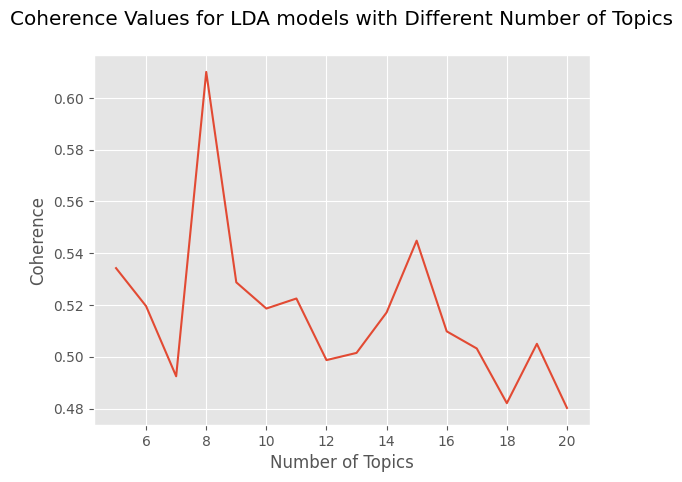

In [12]:
# CHD optimal number of topics
optimal_topics(sector_df_corpus)

Optimal number of topics for the sector: 8

#### 3.2. LDA model for the sector

After identifying the optimal number of topics, we create the LDA topic model for the sector.


In [88]:
# Model

sector_lda = lda_model(sector_df_corpus,8)

In [89]:
# Visualization

sector_tfidf_corpus = tfidf_corpus(sector_df_corpus)

pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim_models.prepare(sector_lda, sector_tfidf_corpus[2], sector_tfidf_corpus[1])

pyLDAvis.save_html(LDAvis_prepared, 'LDAvis_tfidf_sector' + str(7) +'.html')


In [90]:
IPython.display.HTML(filename= 'LDAvis_tfidf_sector' + str(7) +'.html')

### 3.3. Bag of Words model for the sector

And we also create a BoW model for the sector, to think of patent pairwise similarity without using LDA.

In [91]:
sector_bow = bow_model(sector_df_corpus)
print("Shape of BoW matrix =", sector_bow.shape)
sector_bow

Shape of BoW matrix = (427, 7724)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### 4. Within-sector novelty/similarity 

#### 4.1 LDA model cosine-similarity

To obtain a patent specific measure of novelty we:

a. Obtained the theta parameters (topics weights) for each patent.

b. Calculated the distance between a patent and the previous ones using the theta parameters and cosine similarity.

c. Created three measures by averaging the distance of one patent with the 5, 10 and 20 previous patents. 

In [92]:
# Get the theta parameters for each patent

def theta_param(corpus, model):
    theta_array = []
    tfidf_corpus_outputs = tfidf_corpus(corpus)

    for document in tfidf_corpus_outputs[4]:
        doc_topics = model.get_document_topics(document, minimum_probability=0.0)
        topic_weights = [(topic_id, weight) for topic_id, weight in doc_topics]
        theta_array.append(topic_weights)
    
    return theta_array



In [93]:
def similarity_measure(theta_array):
    '''
    This function calculates the cosine similarity between each document and the previous 5, 10 and 20 documents, 
    using the topics' weights of each patent.
    '''
    # Initialize an empty list to store the results
    result_data = []

    # Iterate over all the documents
    for document_index in range(len(theta_array)):
        previous_documents = [i for i in range(document_index)]

        similarities = []

        for prev_index in previous_documents:
            similarity = gensim.matutils.cossim(theta_array[document_index], theta_array[prev_index])
            similarities.append(similarity)

        avg_similarity_5 = np.mean(similarities[:5])
        avg_similarity_10 = np.mean(similarities[:10])
        avg_similarity_20 = np.mean(similarities[:20])

        # Append the results to the list
        result_data.append({'lda_avg_similarity_5': avg_similarity_5,
                            'lda_avg_similarity_10': avg_similarity_10,
                            'lda_avg_similarity_20': avg_similarity_20})

    # Create the DataFrame from the list of dictionaries
    result_df = pd.DataFrame(result_data)

    return result_df

In [116]:
sector_theta_array = theta_param(sector_df_corpus, sector_lda)
lda_sector_similarity = similarity_measure(sector_theta_array)
lda_sector_similarity

,lda_avg_similarity_5,lda_avg_similarity_10,lda_avg_similarity_20
0,NaN,NaN,NaN
1,0.185381,0.185381,0.185381
2,0.368466,0.368466,0.368466
3,0.284368,0.284368,0.284368
4,0.598208,0.598208,0.598208
...,...,...,...
422,0.544690,0.557915,0.479019
423,0.178791,0.223766,0.293382
424,0.182863,0.230967,0.235251
425,0.231861,0.148916,0.178696


Since we are measuring the distance of a patent with the previous 5, 10 and 20, for the first patent of the period we could not calculate the measurements. Also, all three measures start out the same until it get to the point where there are 10 and 20 prior patents.

### 4.2 BoW model cosine-similarity

In this case to obtain a patent specific measure of novelty we addapt the previous code to do the following:

a. Calculate the cosine similarity between the current document and each previous document.

b. Created three measures by averaging the distance of one patent with the 5, 10 and 20 previous patents. 

In [96]:

def bow_similarity_measure(bow_corpus):
    '''
    This function calculates the cosine similarity between each document and the previous 5, 10, and 20 documents
    using the Bag-of-Words (BoW) representation.

    '''
    # Initialize an empty list to store the results
    result_data = []

    # Iterate over all the documents
    for document_index in range(len(bow_corpus)):
        previous_documents = [i for i in range(max(0, document_index - 20), document_index)]

        similarities = []

        for prev_index in previous_documents:
            similarity = cosine_similarity(bow_corpus[document_index].reshape(1, -1), 
                                           bow_corpus[prev_index].reshape(1, -1))
            similarities.append(similarity[0][0])

        avg_similarity_5 = np.mean(similarities[:5])
        avg_similarity_10 = np.mean(similarities[:10])
        avg_similarity_20 = np.mean(similarities[:20])

        # Append the results to the list
        result_data.append({'bow_avg_similarity_5': avg_similarity_5,
                            'bow_avg_similarity_10': avg_similarity_10,
                            'bow_avg_similarity_20': avg_similarity_20})

    # Create the DataFrame from the list of dictionaries
    result_df = pd.DataFrame(result_data)

    return result_df


In [97]:
bow_sector_similarity = bow_similarity_measure(sector_bow)
bow_sector_similarity.head()

,bow_avg_similarity_5,bow_avg_similarity_10,bow_avg_similarity_20
0,NaN,NaN,NaN
1,0.123194,0.123194,0.123194
2,0.135269,0.135269,0.135269
3,0.113885,0.113885,0.113885
4,0.112858,0.112858,0.112858


### 5. Data merge

In [98]:
# Concatenate original df with new variables

sector_final = pd.concat([sector_df,lda_sector_similarity], axis=1)
sector_final = pd.concat([sector_final,bow_sector_similarity], axis=1)
sector_final.head(5)

,text,patent_id,ticker,numpat_total,issue_date,sector,clean_corpus,lda_avg_similarity_5,lda_avg_similarity_10,lda_avg_similarity_20,bow_avg_similarity_5,bow_avg_similarity_10,bow_avg_similarity_20
0,FIELD OF THE INVENTION AND INTRODUCTION\n\nThe...,7641930,HSY,27,2010-01-05,Consumer Staples,field invent introduct invent relat novel meth...,NaN,NaN,NaN,NaN,NaN,NaN
1,FIELD OF THE INVENTION\n\nThe present inventio...,7665418,CHD,395,2010-02-23,Consumer Staples,field invent present invent relat absorb compo...,0.185326,0.185326,0.185326,0.123194,0.123194,0.123194
2,This invention is directed to a dispensing con...,7690531,CL,3401,2010-04-06,Consumer Staples,invent direct dispens contain enhanc appear pa...,0.368513,0.368513,0.368513,0.135269,0.135269,0.135269
3,BACKGROUND OF THE INVENTION\n\nHard surface cl...,7700536,CL,3401,2010-04-20,Consumer Staples,background invent hard surfac cleaner usual wa...,0.284316,0.284316,0.284316,0.113885,0.113885,0.113885
4,FIELD OF THE INVENTION\n\nThe present inventio...,7703163,CL,3401,2010-04-27,Consumer Staples,field invent present invent relat toothbrush m...,0.598189,0.598189,0.598189,0.112858,0.112858,0.112858


In [99]:
sector_final = sector_final.sort_values(by='issue_date').reset_index(drop=True)

In [100]:
import glob
import pandas as pd

path = '../data/novelty_sam_arts/'

file_list = glob.glob(path + "novelty*.xlsx")

excl_list = []
 
for file in file_list:
    excl_list.append(pd.read_excel(file))
 
novelty_sam_arts = pd.concat(excl_list, ignore_index=True)

# Display the merged DataFrame
print(novelty_sam_arts)


          patent  year  nw  nb  nt  nwc       nov
0        8754048  2014   0   1   2   88  0.980557
1        8851511  2014   0   0   0   39  0.982333
2        8827802  2014   0   1   0    5  0.978557
3        8776500  2014   0   0   0   13  0.969101
4        8726286  2014   0   0   0   16  0.984629
...          ...   ...  ..  ..  ..  ...       ...
2333082  9863293  2018   0   0   0    0  0.969480
2333083  9925424  2018   0   0   0    0  0.979475
2333084  9901419  2018   0   0   0   10  0.981248
2333085  9890376  2018   0   0   1   86  0.976084
2333086  9981014  2018   0   0   0    0  0.994009

[2333087 rows x 7 columns]


In [105]:
novelty_sam_arts['patent'].duplicated().sum()

0

In [106]:
# Final dataset with sam arts novelties and measures created

all_novelty = pd.merge(sector_final, novelty_sam_arts[['patent','nw', 'nb', 'nt', 'nwc', 'nov']], 
                       how="left", left_on='patent_id', right_on='patent')
all_novelty = all_novelty.drop(columns=['patent'])
all_novelty


,text,patent_id,ticker,numpat_total,issue_date,sector,clean_corpus,lda_avg_similarity_5,lda_avg_similarity_10,lda_avg_similarity_20,bow_avg_similarity_5,bow_avg_similarity_10,bow_avg_similarity_20,nw,nb,nt,nwc,nov
0,FIELD OF THE INVENTION AND INTRODUCTION\n\nThe...,7641930,HSY,27,2010-01-05,Consumer Staples,field invent introduct invent relat novel meth...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,10.0,34.0,390.0,0.988917
1,FIELD OF THE INVENTION\n\nThe present inventio...,7665418,CHD,395,2010-02-23,Consumer Staples,field invent present invent relat absorb compo...,0.185326,0.185326,0.185326,0.123194,0.123194,0.123194,0.0,1.0,0.0,70.0,0.990278
2,This invention is directed to a dispensing con...,7690531,CL,3401,2010-04-06,Consumer Staples,invent direct dispens contain enhanc appear pa...,0.368513,0.368513,0.368513,0.135269,0.135269,0.135269,0.0,1.0,1.0,0.0,0.962962
3,BACKGROUND OF THE INVENTION\n\nHard surface cl...,7700536,CL,3401,2010-04-20,Consumer Staples,background invent hard surfac cleaner usual wa...,0.284316,0.284316,0.284316,0.113885,0.113885,0.113885,0.0,0.0,0.0,3.0,0.983057
4,FIELD OF THE INVENTION\n\nThe present inventio...,7703163,CL,3401,2010-04-27,Consumer Staples,field invent present invent relat toothbrush m...,0.598189,0.598189,0.598189,0.112858,0.112858,0.112858,0.0,0.0,0.0,2.0,0.976839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422,FIELD OF THE INVENTION\n\nThis invention is di...,9949916,CHD,395,2018-04-24,Consumer Staples,field invent invent direct non-irrit person lu...,0.544659,0.557927,0.479045,0.189591,0.217209,0.166483,0.0,0.0,0.0,25.0,0.983442
423,FIELD OF THE INVENTION\n\nThe invention relate...,9970923,CHD,395,2018-05-15,Consumer Staples,field invent invent relat diagnost assay analy...,0.178689,0.223721,0.293358,0.114194,0.232313,0.221636,0.0,0.0,0.0,0.0,0.949941
424,BACKGROUND\n\nField of the Invention\n\nThe pr...,10001449,CHD,395,2018-06-19,Consumer Staples,background field invent present invent relat d...,0.182849,0.230987,0.235285,0.069609,0.110788,0.143621,NaN,NaN,NaN,NaN,NaN
425,BACKGROUND OF THE INVENTION\n\nField of the In...,10101342,CHD,395,2018-10-16,Consumer Staples,background invent field invent present invent ...,0.231868,0.148888,0.178720,0.184833,0.184637,0.224240,NaN,NaN,NaN,NaN,NaN


In [107]:
all_novelty.to_csv('../data/all_novelty_within_sector.csv', index=False) # Data to be used for prediction

### 6. Comparing novelty measures Sam Arts paper with our measures

Novelty measures Sam Arts paper:

- nw: new words 
- nb: new bigrams (two consecutive words)
- nt: new trigrams (three consecutive words)
- nwc: new word combinations
- nov: novelty (average cosine similarity between a focal patent and all patents filed in the five years before/after the focal patent)

#### 6.1. LDA Average Similarities 

First, we start by examining the distribution of the similarity measures created by us. It can be observed that for all three measures, the values range between 0 and 1, suggesting that the new patents are not very innovative compared to the previous ones.

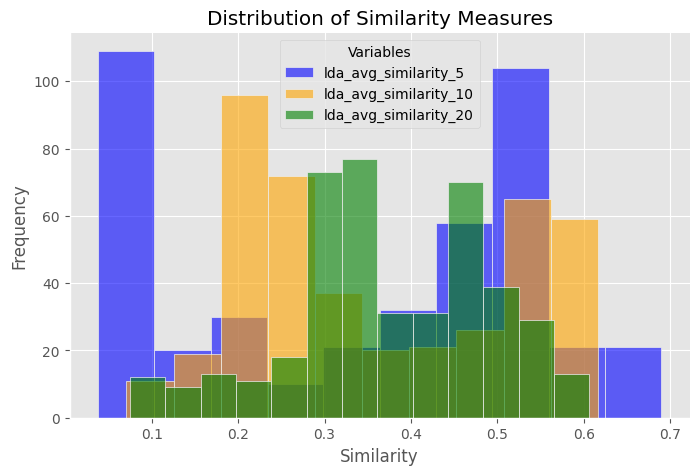

In [108]:
variables = ['lda_avg_similarity_5', 'lda_avg_similarity_10', 'lda_avg_similarity_20']

fig, ax = plt.subplots(figsize=(8, 5))
colors = ['blue', 'orange', 'green']  

for i, variable in enumerate(variables):
    sns.histplot(data=all_novelty, x=variable, ax=ax, label=variable, color=colors[i], alpha=0.6)

ax.set_xlabel('Similarity')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Similarity Measures')
ax.legend(title='Variables')
sns.despine() 

plt.show()

Secondly, we analyze the correlation between our measures and those from the paper.

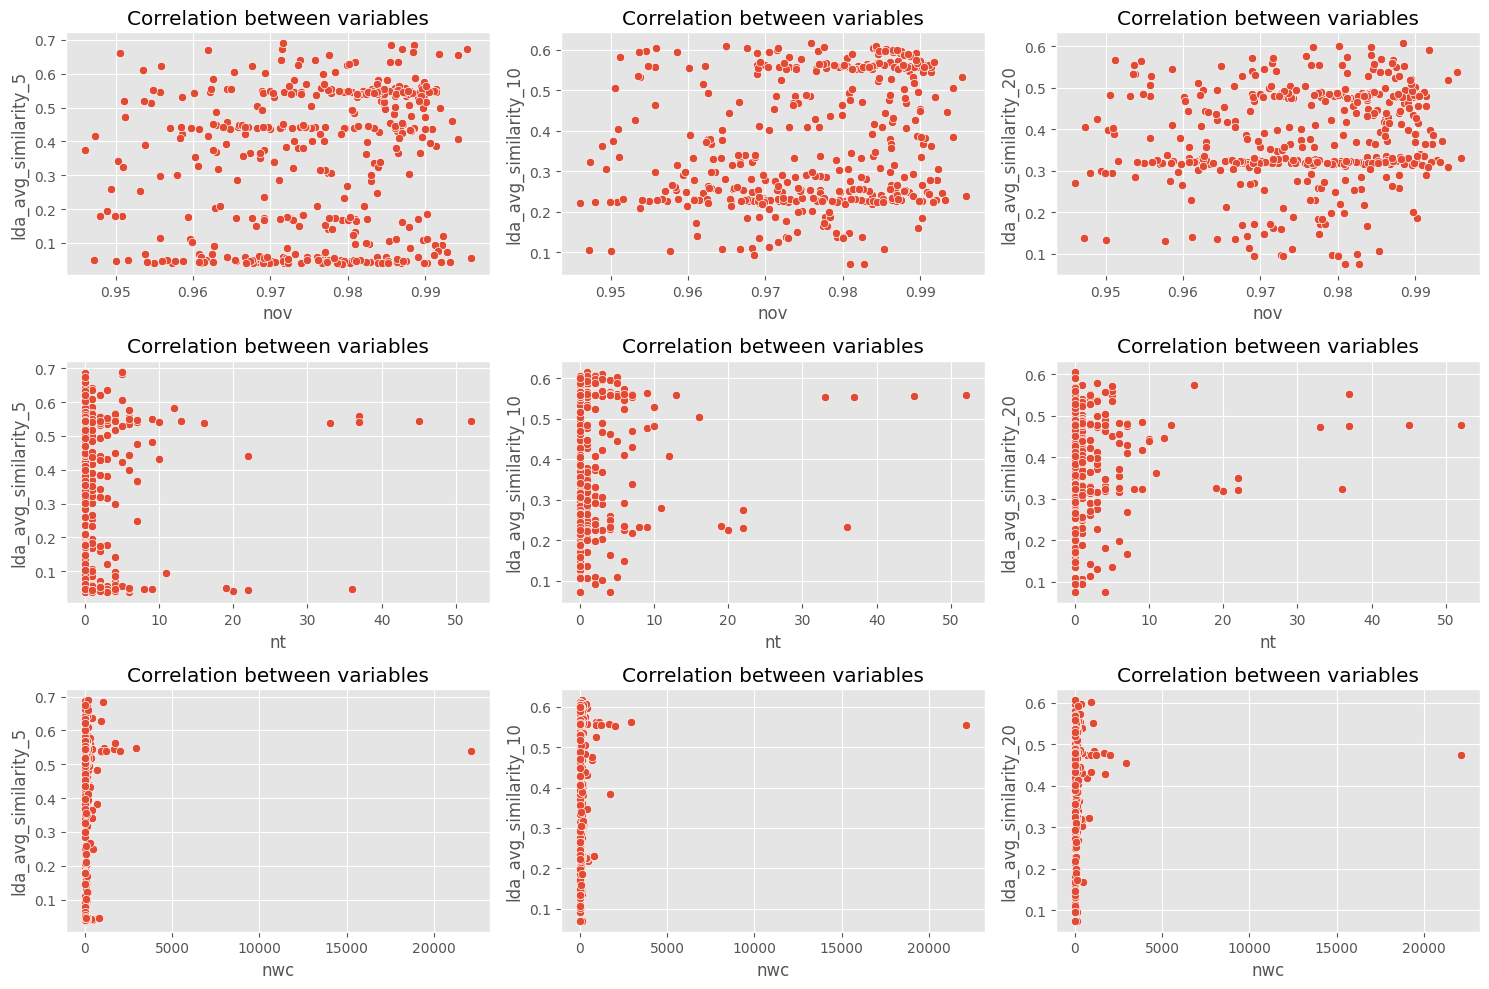

In [109]:
sams_variables = ['nov', 'nt', 'nwc']

fig, axes = plt.subplots(nrows=len(sams_variables), ncols=len(variables), figsize=(15, 10))

for i, sams_variable in enumerate(sams_variables):
    for j, variable in enumerate(variables):
        sns.scatterplot(data=all_novelty, x=sams_variable, y=variable, ax=axes[i, j])
        axes[i, j].set_xlabel(sams_variable)
        axes[i, j].set_ylabel(variable)
        axes[i, j].set_title(f'Correlation between variables')

plt.tight_layout()
plt.show()


In [111]:
correlation_5 = all_novelty['nov'].corr(all_novelty['lda_avg_similarity_5'])
correlation_10 = all_novelty['nov'].corr(all_novelty['lda_avg_similarity_10'])
correlation_20 = all_novelty['nov'].corr(all_novelty['lda_avg_similarity_20'])
print("Correlation novelty - similarity(5 patents): ", correlation_5)
print("Correlation novelty - similarity(10 patents): ", correlation_10)
print("Correlation novelty - similarity(20 patents): ", correlation_20)

Correlation novelty - similarity(5 patents):  0.18620483899736054
Correlation novelty - similarity(10 patents):  0.24439517857590837
Correlation novelty - similarity(20 patents):  0.1574707937751898


 In this case, we can see a low correlation by observing the graphs and a positive correlation observing the calculated coefficients. One possible explanation is that the paper directly analyzes words rather than topics, which can impact novelty since there is a higher probability of incorporating new words rather than new topics. Another reason could be that in our case, the measures compare patents within the same sector. Therefore, it is more likely to find greater distances between patents from different companies and sectors than within the same sector over the time.

#### 6.2 LDA Average Similarities

First, we start by examining the distribution of the similarity measures created by us. It can be observed that for all three measures, the values range between 0 and 0.5, meaning that the similarity measures tend to be concentrated towards zero. This indicates that, on average, there is a lower similarity between the current document and the previous 5, 10, and 20 documents.

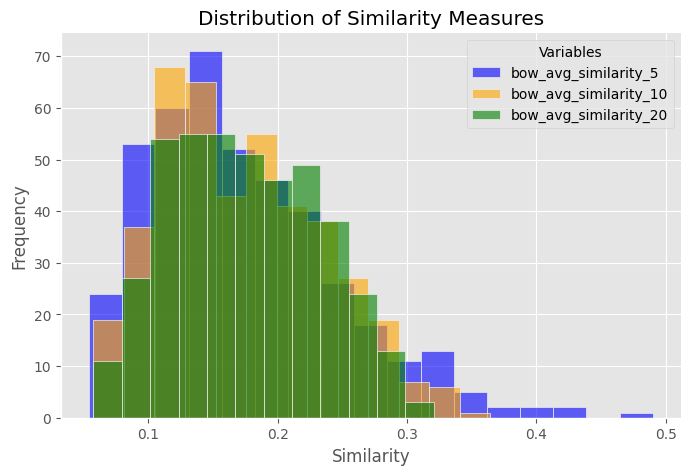

In [112]:
variables = ['bow_avg_similarity_5', 'bow_avg_similarity_10', 'bow_avg_similarity_20']

fig, ax = plt.subplots(figsize=(8, 5))
colors = ['blue', 'orange', 'green']  

for i, variable in enumerate(variables):
    sns.histplot(data=all_novelty, x=variable, ax=ax, label=variable, color=colors[i], alpha=0.6)

ax.set_xlabel('Similarity')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Similarity Measures')
ax.legend(title='Variables')
sns.despine() 

plt.show()

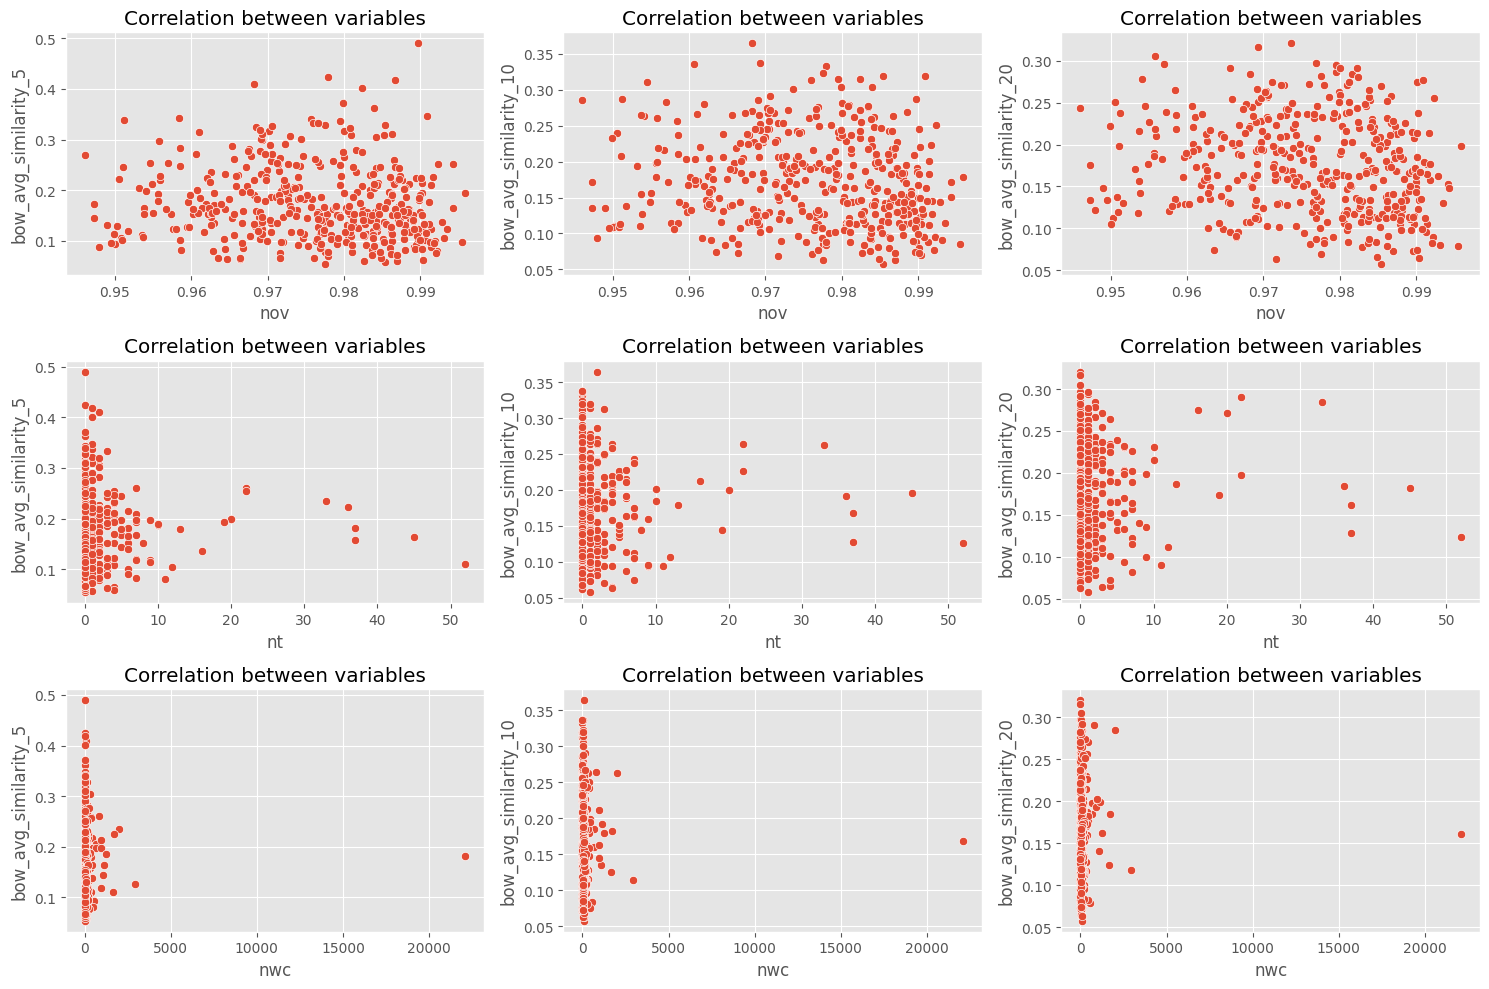

In [113]:
sams_variables = ['nov', 'nt', 'nwc']

fig, axes = plt.subplots(nrows=len(sams_variables), ncols=len(variables), figsize=(15, 10))

for i, sams_variable in enumerate(sams_variables):
    for j, variable in enumerate(variables):
        sns.scatterplot(data=all_novelty, x=sams_variable, y=variable, ax=axes[i, j])
        axes[i, j].set_xlabel(sams_variable)
        axes[i, j].set_ylabel(variable)
        axes[i, j].set_title(f'Correlation between variables')

plt.tight_layout()
plt.show()

In [115]:
correlation_5 = all_novelty['nov'].corr(all_novelty['bow_avg_similarity_5'])
correlation_10 = all_novelty['nov'].corr(all_novelty['bow_avg_similarity_10'])
correlation_20 = all_novelty['nov'].corr(all_novelty['bow_avg_similarity_20'])
print("Correlation novelty - similarity(5 patents): ", correlation_5)
print("Correlation novelty - similarity(10 patents): ", correlation_10)
print("Correlation novelty - similarity(20 patents): ", correlation_20)

Correlation novelty - similarity(5 patents):  -0.10058147492325845
Correlation novelty - similarity(10 patents):  -0.14888097927417132
Correlation novelty - similarity(20 patents):  -0.1540401336036135


One possible explanation is that the paper directly analyzes words rather than topics, which can impact novelty since there is a higher probability of incorporating new words rather than new topics. Another reason could be that in our case, the measures compare patents within the same sector. Therefore, it is more likely to find greater distances between patents from different companies and sectors than within the same sector over the time.

In this case, the correlation values (-0.1006, -0.1489, and -0.1540) indicate a weak negative correlation between novelty and similarity measures when considering the previous 5, 10, and 20 patents, respectively. This implies that as the novelty of a patent increases, there is a slight tendency for the similarity measures to decrease, but the relationship is not very strong. These correlation values suggest that there is some level of distinction or uniqueness in the patents with higher novelty scores, as they exhibit lower similarity with the previous patents, however, it's important to note that the correlations are relatively small.
